In [1]:
import os
import shutil
import random
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# --- Configuration ---
# Dataset Paths
SOURCE_DATA_DIR = 'images/'       # Folder containing original class subfolders
BASE_DATA_SPLIT_DIR = 'data_split/' # Folder where split data will be stored
TRAIN_DIR = os.path.join(BASE_DATA_SPLIT_DIR, 'train')
VAL_DIR = os.path.join(BASE_DATA_SPLIT_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DATA_SPLIT_DIR, 'test')

# Split Ratios (Must sum to 1.0 as per methodology )
TRAIN_RATIO = 0.84
VAL_RATIO = 0.08
TEST_RATIO = 0.08

# Model Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20

In [2]:
def split_dataset(source, destination, train_r, val_r, test_r, force_resplit=False):
    """
    Splits images from source into train/val/test directories in destination.
    """
    if not os.path.exists(source):
        logger.error(f"Source directory '{source}' not found. Please ensure your 'images' folder exists.")
        return

    if os.path.exists(destination) and not force_resplit:
        logger.info(f"Split directory '{destination}' already exists. Skipping re-split.")
        return

    logger.info(f"Starting dataset split from '{source}' to '{destination}'...")

    # Ensure base directories exist
    for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        os.makedirs(d, exist_ok=True)

    class_counts = defaultdict(lambda: {'train': 0, 'val': 0, 'test': 0, 'total': 0})

    for class_name in os.listdir(source):
        class_source_path = os.path.join(source, class_name)
        if not os.path.isdir(class_source_path):
            continue

        # Create class subdirectories in split folders
        for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
            os.makedirs(os.path.join(d, class_name), exist_ok=True)

        # Get and shuffle files
        files = [f for f in os.listdir(class_source_path) if os.path.isfile(os.path.join(class_source_path, f))]
        if not files:
            continue
        
        random.shuffle(files)
        total = len(files)
        class_counts[class_name]['total'] = total

        # Calculate split indices
        train_end = int(total * train_r)
        val_end = train_end + int(total * val_r)

        # Assign files
        splits = {
            'train': (files[:train_end], TRAIN_DIR),
            'val': (files[train_end:val_end], VAL_DIR),
            'test': (files[val_end:], TEST_DIR)
        }

        # Copy files
        for split_name, (split_files, split_dir) in splits.items():
            for file_name in split_files:
                src = os.path.join(class_source_path, file_name)
                dst = os.path.join(split_dir, class_name, file_name)
                try:
                    shutil.copy2(src, dst)
                    class_counts[class_name][split_name] += 1
                except Exception as e:
                    logger.error(f"Error copying {file_name}: {e}")

    # Log results
    logger.info("\n--- Data Split Summary ---")
    for cls, counts in class_counts.items():
         logger.info(f"{cls:<15} | Total: {counts['total']:<4} | Train: {counts['train']:<4} | Val: {counts['val']:<4} | Test: {counts['test']:<4}")
    logger.info("--------------------------")

# Execute the split
# Set force_resplit=True if you add new images and need to regenerate the splits
split_dataset(SOURCE_DATA_DIR, BASE_DATA_SPLIT_DIR, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, force_resplit=False)

INFO: Split directory 'data_split/' already exists. Skipping re-split.


In [3]:
logger.info("Initializing Data Generators...")

# Training generator with data augmentation [cite: 223, 289]
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test generator (rescaling only)
val_test_datagen = ImageDataGenerator(rescale=1./255)

try:
    # Flow from directories
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=1,     # Batch size 1 for accurate individual predictions during testing
        class_mode='categorical',
        shuffle=False     # Essential for consistent evaluation results
    )

    # Identify classes
    class_labels = list(train_generator.class_indices.keys())
    num_classes = len(class_labels)
    logger.info(f"Classes detected ({num_classes}): {class_labels}")

except Exception as e:
    logger.error(f"Failed to create data generators: {e}")
    logger.error("Ensure 'images' folder is populated and split_dataset has run successfully.")

INFO: Initializing Data Generators...


Found 1026 images belonging to 11 classes.
Found 93 images belonging to 11 classes.
Found 108 images belonging to 11 classes.


INFO: Classes detected (11): ['Akok', 'Cek Mek Molek', 'Ketayap', 'Kole Kacang', 'Kuih Bakar', 'Kuih Lapis', 'Kuih Lompang', 'Kuih Qasidah', 'Onde-onde', 'Pulut Sekaya', 'Seri Muka']


In [4]:
#START MODEL_TRAINING =====================================================================================================

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report # For evaluation

# Configure logging (optional, but good practice)
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

In [6]:
# %% [markdown]
# ## 2. Configuration
# Define constants and paths used throughout the notebook.

checkpoint = ModelCheckpoint('best_kuih_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)

# %%
# --- Data Configuration ---
IMG_SIZE = (224, 224) # Standard input size for MobileNetV2
BATCH_SIZE = 32
BASE_DATA_DIR = 'data_split/' # Base directory created by split_dataset.py
TRAIN_DIR = os.path.join(BASE_DATA_DIR, 'train')
VAL_DIR = os.path.join(BASE_DATA_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DATA_DIR, 'test')

In [7]:
# --- Model Configuration ---
LEARNING_RATE = 0.001 # Initial learning rate for Adam optimizer
MODEL_SAVE_PATH = 'kuih_recognition_model.keras' # Path to save the trained model

# --- Training Configuration ---
EPOCHS_TO_TRAIN = 20 # Adjust based on performance during training

In [8]:
logger.info("Initializing Data Generators for ResNet50...")

# Training generator with data augmentation AND ResNet specific preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # CHANGED: Replaced rescale=1./255
    rotation_range=30,      # Slightly increased rotation for tougher training
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,     # Added vertical flip for top-down food shots
    fill_mode='nearest'
)

# Validation/Test generator (preprocessing only, NO augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # CHANGED: Replaced rescale=1./255
)

try:
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )
except Exception as e:
    logger.error(f"Generator Error: {e}")

# --- Output Confirmation ---
if train_generator.samples == 0:
    logger.error("No training images found. Check the 'train' directory.")
    raise ValueError("No training images found.")

logger.info(f"Found {train_generator.samples} images for training in '{TRAIN_DIR}'.")
logger.info(f"Found {validation_generator.samples} images for validation in '{VAL_DIR}'.")
logger.info(f"Found {test_generator.samples} images for testing in '{TEST_DIR}'.")

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())
logger.info(f"Detected {num_classes} classes: {class_labels}")
logger.info(f"Class Indices: {train_generator.class_indices}")

INFO: Initializing Data Generators for ResNet50...


Found 1026 images belonging to 11 classes.
Found 93 images belonging to 11 classes.
Found 108 images belonging to 11 classes.


INFO: Found 1026 images for training in 'data_split/train'.
INFO: Found 93 images for validation in 'data_split/validation'.
INFO: Found 108 images for testing in 'data_split/test'.
INFO: Detected 11 classes: ['Akok', 'Cek Mek Molek', 'Ketayap', 'Kole Kacang', 'Kuih Bakar', 'Kuih Lapis', 'Kuih Lompang', 'Kuih Qasidah', 'Onde-onde', 'Pulut Sekaya', 'Seri Muka']
INFO: Class Indices: {'Akok': 0, 'Cek Mek Molek': 1, 'Ketayap': 2, 'Kole Kacang': 3, 'Kuih Bakar': 4, 'Kuih Lapis': 5, 'Kuih Lompang': 6, 'Kuih Qasidah': 7, 'Onde-onde': 8, 'Pulut Sekaya': 9, 'Seri Muka': 10}


In [9]:
logger.info("Building ResNet50-based model...")

# 1. Load ResNet50 base model
base_model = ResNet50(
    input_shape=IMG_SIZE + (3,), # Ensures (224, 224, 3)
    include_top=False,           # Exclude original 1000-class classification layer
    weights='imagenet'           # Load pre-trained weights
)

# 2. Freeze the base model
base_model.trainable = False

# 3. Add custom layers for 10-class Kuih recognition
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) # Increased from 128 for the larger ResNet model
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# 4. Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

INFO: Building ResNet50-based model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,115,083 (91.99 MB)

 Trainable params: 527,371 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
# %% [markdown]
# ## 5. Model Training (Phase 3 - Algorithm Implementation)
# Train the model using the prepared data generators.

# %%
logger.info(f"Starting model training for {EPOCHS_TO_TRAIN} epochs...")

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Adjust steps if dataset size is smaller than batch size
if steps_per_epoch == 0:
    steps_per_epoch = 1
    logger.warning(f"Training dataset smaller than batch size. Setting steps_per_epoch=1.")
if validation_steps == 0 and validation_generator.samples > 0:
    validation_steps = 1
    logger.warning(f"Validation dataset smaller than batch size. Setting validation_steps=1.")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50, # Increase epochs since EarlyStopping will handle stopping
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, reduce_lr] # Add callbacks here
)

logger.info("Model training completed.")

INFO: Starting model training for 20 epochs...
C:\Users\rahim\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3381 - loss: 2.5145
Epoch 1: val_accuracy improved from -inf to 0.85938, saving model to best_kuih_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.3428 - loss: 2.4919 - val_accuracy: 0.8594 - val_loss: 0.4999 - learning_rate: 0.0010
Epoch 2/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8125 - loss: 0.6471

C:\Users\rahim\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.85938
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.8125 - loss: 0.6471 - val_accuracy: 0.8594 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8010 - loss: 0.6532
Epoch 3: val_accuracy did not improve from 0.85938
32/32 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.8017 - loss: 0.6507 - val_accuracy: 0.8594 - val_loss: 0.2963 - learning_rate: 0.0010
Epoch 4/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8125 - loss: 0.5150
Epoch 4: val_accuracy did not improve from 0.85938
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - accuracy: 0.8125 - loss: 0.5150 - val_accuracy: 0.8594 - val_loss: 0.2936 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8868 - loss: 0.3778
Epoch 5: val_accuracy improved from 0.85938 to 0.98438, saving model to best_kuih_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.8867 - loss: 0.3777 - va

INFO: Model training completed.


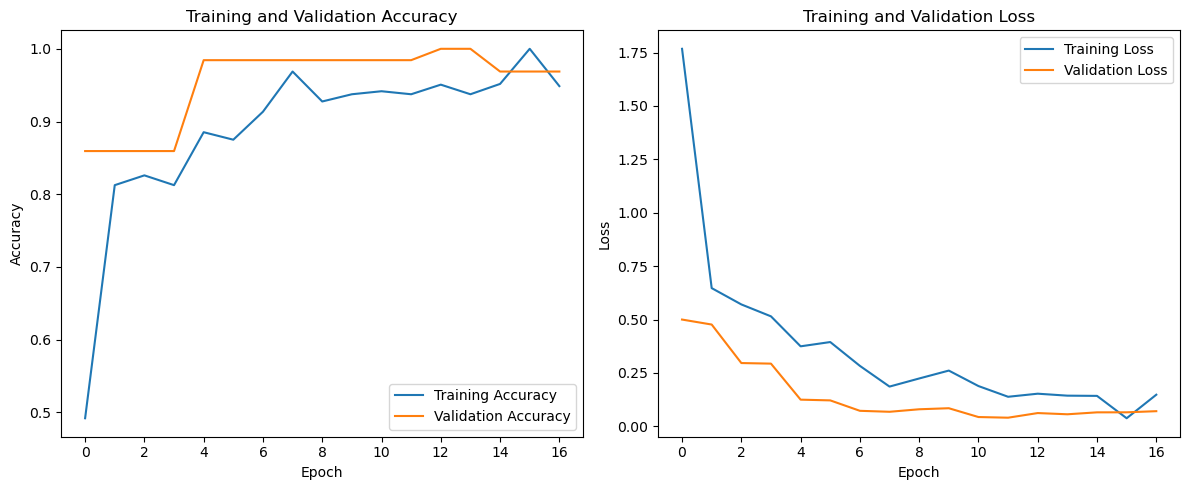

In [11]:
# %% [markdown]
# ## 6. Visualize Training History
# Plot accuracy and loss curves for training and validation sets.

# %%
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# FIX: Dynamically determine the range based on actual training length
actual_epochs = len(acc)
epochs_range = range(actual_epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [12]:
# %% [markdown]
# ## 7. Save the Trained Model
# Save the model to a file for later use in the web application.

# %%
try:
    model.save(MODEL_SAVE_PATH)
    logger.info(f"Trained model saved successfully to '{MODEL_SAVE_PATH}'")
except Exception as e:
    logger.error(f"Error saving model: {e}")

INFO: Trained model saved successfully to 'kuih_recognition_model.keras'


INFO: Evaluating model on the test set...


108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9779 - loss: 0.0818


INFO: Test Loss: 0.1622
INFO: Test Accuracy: 0.9537


108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step


INFO: 
--- Classification Report ---


               precision    recall  f1-score   support

         Akok       0.90      1.00      0.95         9
Cek Mek Molek       1.00      1.00      1.00         3
      Ketayap       0.94      1.00      0.97        16
  Kole Kacang       0.83      1.00      0.91        10
   Kuih Bakar       1.00      0.89      0.94         9
   Kuih Lapis       1.00      1.00      1.00         9
 Kuih Lompang       1.00      0.92      0.96        12
 Kuih Qasidah       1.00      1.00      1.00         4
    Onde-onde       1.00      0.86      0.92        14
 Pulut Sekaya       1.00      0.90      0.95        10
    Seri Muka       0.92      1.00      0.96        12

     accuracy                           0.95       108
    macro avg       0.96      0.96      0.96       108
 weighted avg       0.96      0.95      0.95       108



INFO: 
Overall Metrics (Weighted Avg):
INFO:   Accuracy: 0.9537
INFO:   Precision: 0.9590
INFO:   Recall: 0.9537
INFO:   F1-Score: 0.9537
INFO: 
--- Confusion Matrix ---


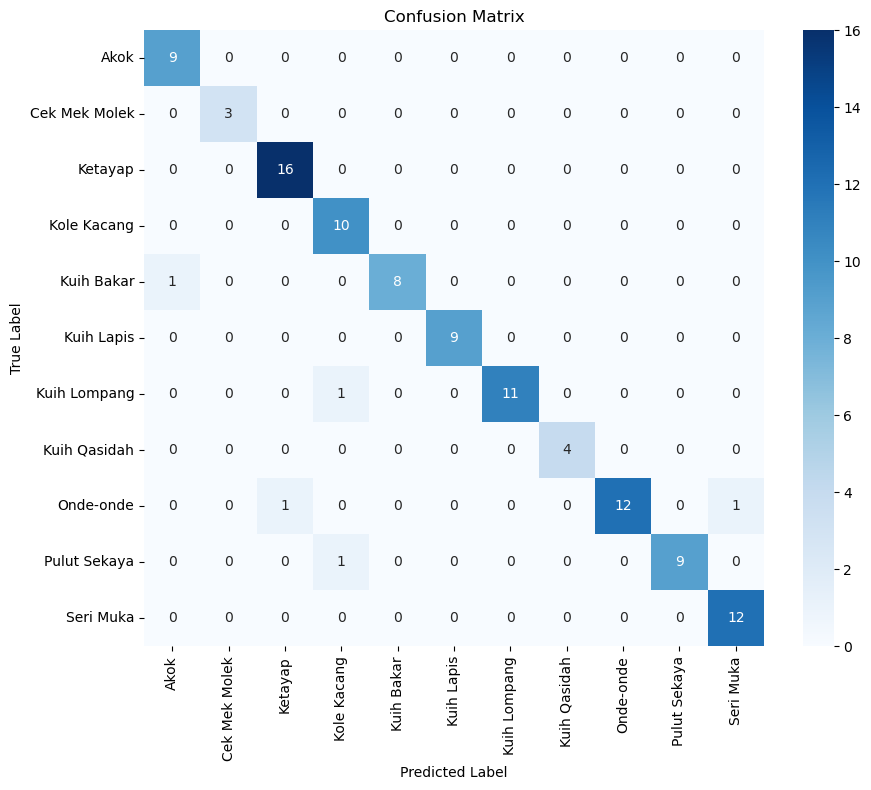

INFO: --- Performance Evaluation Finished ---


In [13]:
# %% [markdown]
# ## 8. Performance Evaluation (Phase 4)
# [cite_start]Evaluate the trained model on the independent test set using standard metrics. [cite: 976-978, 991]

# %%
if test_generator and test_generator.samples > 0:
    logger.info("Evaluating model on the test set...")

    # Ensure generator is reset
    test_generator.reset()

    # Evaluate loss and accuracy on the test set
    test_loss, test_acc = model.evaluate(test_generator, verbose=1) # Let Keras determine steps
    logger.info(f"Test Loss: {test_loss:.4f}")
    logger.info(f"Test Accuracy: {test_acc:.4f}")

    # Generate predictions for classification report and confusion matrix
    test_generator.reset() # Reset again before predicting
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes

    # Ensure we have the correct number of labels for the report
    target_names = list(test_generator.class_indices.keys())

    # [cite_start]Generate Classification Report [cite: 180, 876, 991-1021]
    logger.info("\n--- Classification Report ---")
    try:
        report = classification_report(true_classes, predicted_classes, target_names=target_names, zero_division=0)
        print(report)
        # [cite_start]Extract overall metrics mentioned in the proposal [cite: 180, 991]
        report_dict = classification_report(true_classes, predicted_classes, target_names=target_names, output_dict=True, zero_division=0)
        accuracy = report_dict['accuracy']
        precision = report_dict['weighted avg']['precision']
        recall = report_dict['weighted avg']['recall']
        f1_score = report_dict['weighted avg']['f1-score']
        logger.info(f"\nOverall Metrics (Weighted Avg):")
        logger.info(f"  Accuracy: {accuracy:.4f}")
        logger.info(f"  Precision: {precision:.4f}")
        logger.info(f"  Recall: {recall:.4f}")
        logger.info(f"  F1-Score: {f1_score:.4f}")

    except ValueError as e:
        logger.error(f"Error generating classification report: {e}")
        logger.error(f"Unique true classes: {np.unique(true_classes)}")
        logger.error(f"Unique predicted classes: {np.unique(predicted_classes)}")
        logger.error(f"Target names: {target_names}")
    except Exception as e:
         logger.error(f"An unexpected error occurred during classification report generation: {e}")


    # [cite_start]Generate Confusion Matrix [cite: 231, 619, 876]
    logger.info("\n--- Confusion Matrix ---")
    try:
        cm = confusion_matrix(true_classes, predicted_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
    except Exception as e:
        logger.error(f"Error generating confusion matrix: {e}")

else:
    logger.warning("Test generator is not available or has no samples. Skipping final evaluation.")

logger.info("--- Performance Evaluation Finished ---")

# %% [markdown]
# --- End of Notebook ---